In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import layers, optimizers, regularizers
from keras.layers import Embedding, Layer
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import h5py
from kymatio.numpy import Scattering1D

In [2]:
# синтетические данные сгенерированы при помощи библиотеки pyrocko
# файл с синтетическими сигналами - распределение магнитуд задано аналогично реальным данным
file_name = '200k_wforms_displacement_14_10_22.hdf5'
n_signals = 200000 # число синтетических волновых форм в датасете
SNR = 1000 # уровень мощности сигнала относительно шума, SNR=max(abs(wave_form)/3/sigma_noise

In [3]:
# Определение средней "мощности" сигналов в сгенерированной выборке
signal_power = np.zeros(n_signals)
for trace_no in np.arange(n_signals):
    with h5py.File(file_name, 'r') as f:
        signal_power[trace_no] = np.max(np.abs(f["sta1/traces/Z"][trace_no]))
signal_power_avg = np.mean(signal_power)

In [4]:
# Создание датасетa из синтетических волновых форм и сгенерированного шума
sc = Scattering1D(J=4, Q=5, shape=(400,))
X = np.zeros((2*n_signals, 400))
for trace_no in np.arange(n_signals):
    with h5py.File(file_name, 'r') as f:
        X[trace_no] = f["sta1/traces/Z"][trace_no]+np.random.normal(0, signal_power_avg/3/SNR, 400)
for trace_no in np.arange(n_signals, 2*n_signals):
    X[trace_no] = np.random.normal(0, signal_power_avg/3/SNR, 400)

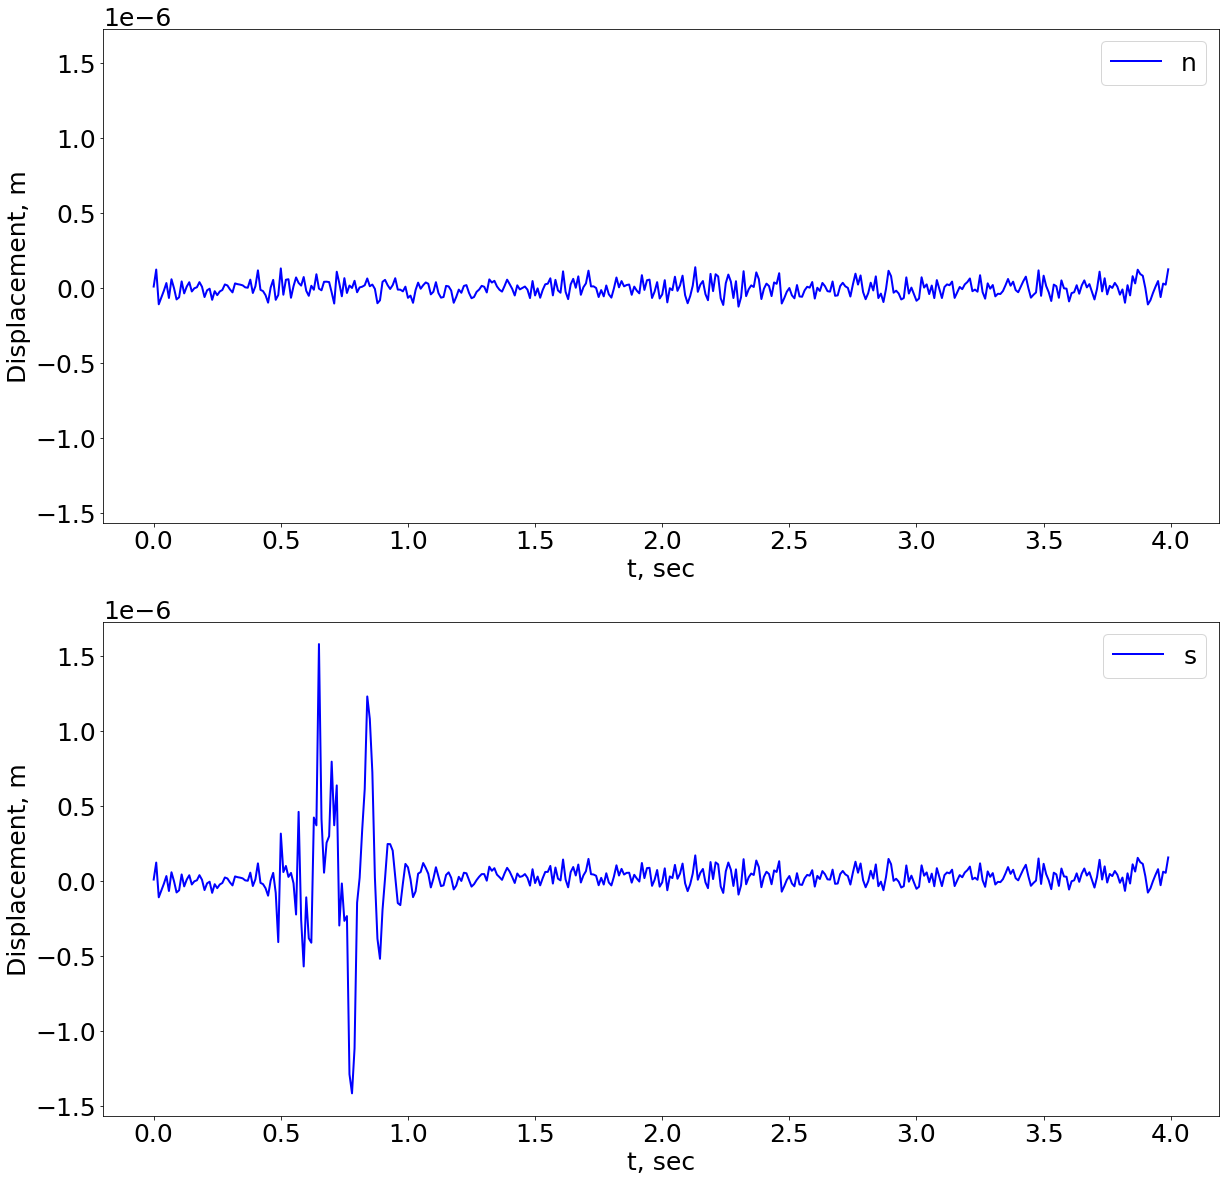

In [21]:
# пример волновой формы, содержащей шум, и содержащей сигнал
trace_no = 520
with h5py.File(file_name, 'r') as f:
    noise = np.random.normal(0, signal_power_avg/3/SNR, 400)
    fig = plt.figure(figsize=(20, 20))
    
    ax1 = fig.add_subplot(211)
    ax1.plot(np.arange(400)/100, noise, linewidth = 2, color='b')
    plt.xlabel('t, sec')
    plt.ylabel('Displacement, m')
    plt.rcParams.update({'font.size': 25})
    plt.legend('noise')
    
    ax2 = fig.add_subplot(212, sharey=ax1)
    ax2.plot(np.arange(400)/100, f["sta1/traces/Z"][trace_no]+noise, linewidth=2, color='b')
    plt.xlabel('t, sec')
    plt.ylabel('Displacement, m')
    plt.rcParams.update({'font.size': 25})
    plt.legend('signal with noise')

In [6]:
# функция для Scattering разложения волновой формы - частотно-временного представления на основе вейвлетов
# https://arxiv.org/pdf/1304.6763.pdf
# подобраны значения параметров J=4, Q=5 для преобразования
def sc_norm(signal):
    sc = Scattering1D(J=4, Q=5, shape=(400,))
    result = sc(signal)
    result_norm = np.zeros((25, 25))
    result_norm[0] = result[1]/sc(np.abs(signal))[0]
    for i in np.arange(1, 25):
        result_norm[i] = result[i+1]/result[i]
    return result_norm

In [7]:
label = np.concatenate((np.ones(n_signals), np.zeros(n_signals)), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, random_state=0, shuffle=True)
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.5, random_state=0, shuffle=True)

In [8]:
X_train_sc = np.zeros((X_train.shape[0], 25, 25))
X_eval_sc = np.zeros((X_eval.shape[0], 25, 25))
X_test_sc = np.zeros((X_test.shape[0], 25, 25))

# Преобразование сигналов 
for trace_no in np.arange(X_train.shape[0]):
    X_train_sc[trace_no] = sc_norm(X_train[trace_no])
for trace_no in np.arange(X_eval.shape[0]):
    X_eval_sc[trace_no] = sc_norm(X_eval[trace_no])
for trace_no in np.arange(X_test.shape[0]):
    X_test_sc[trace_no] = sc_norm(X_test[trace_no])

In [9]:
# Архитектура модели во многом аналогична другим работам по детекции сейсмических сигналов
# https://github.com/smousavi05/EQTransformer
# https://habr.com/ru/post/587690/
class PosEmbeding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PosEmbeding, self).__init__()
        self.num_patches = projection_dim
        self.position_embedding = layers.Embedding(
            input_dim=projection_dim, output_dim=num_patches
        )

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = inputs + tf.transpose(self.position_embedding(positions))
        return encoded

In [10]:
# Энкодер из модели Transformer
# https://arxiv.org/pdf/1706.03762.pdf
# https://habr.com/ru/post/587690/
# https://habr.com/ru/post/486358/
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [11]:
embed_dim = 25 # Embedding size for each token
num_heads = 8 # Number of attention heads
ff_dim = 32 # Hidden layer size in feed forward network inside transformer
input_shape = (25, 25)
vocab_size = 25  
maxlen = 25

inputs = layers.Input(shape=input_shape)
transformer_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_block_3 = TransformerBlock(embed_dim, num_heads, ff_dim)


x = PosEmbeding(num_patches=25, projection_dim=25)(inputs)
x = transformer_block_1(x)
x = transformer_block_2(x)
x = transformer_block_3(x)
x = layers.Flatten()(x)
x = layers.Dense(200,
                 activation="relu",
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(200,
                 activation="relu",
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
# Компиляция
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [13]:
# Обучение
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=5,
        verbose=1)
]
history = model.fit(X_train_sc, y_train,
                    batch_size=100,
                    epochs=100,
                    #callbacks=callbacks,
                    validation_data=(X_eval_sc, y_eval))

Epoch 1/100
2400/2400 [==============================] - 197s 80ms/step - loss: 0.4290 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.3634 - val_sparse_categorical_accuracy: 0.8614
Epoch 2/100
2400/2400 [==============================] - 206s 86ms/step - loss: 0.3414 - sparse_categorical_accuracy: 0.8695 - val_loss: 0.3320 - val_sparse_categorical_accuracy: 0.8693
Epoch 3/100
2400/2400 [==============================] - 217s 90ms/step - loss: 0.3222 - sparse_categorical_accuracy: 0.8759 - val_loss: 0.3198 - val_sparse_categorical_accuracy: 0.8756
Epoch 4/100
2400/2400 [==============================] - 197s 82ms/step - loss: 0.3136 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.3105 - val_sparse_categorical_accuracy: 0.8802
Epoch 5/100
2400/2400 [==============================] - 194s 81ms/step - loss: 0.3086 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.3086 - val_sparse_categorical_accuracy: 0.8811
Epoch 6/100
2400/2400 [==============================] - 194s 81ms/ste

Epoch 45/100
2400/2400 [==============================] - 208s 87ms/step - loss: 0.2728 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.2822 - val_sparse_categorical_accuracy: 0.8933
Epoch 46/100
2400/2400 [==============================] - 209s 87ms/step - loss: 0.2727 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2878 - val_sparse_categorical_accuracy: 0.8910
Epoch 47/100
2400/2400 [==============================] - 210s 87ms/step - loss: 0.2728 - sparse_categorical_accuracy: 0.8982 - val_loss: 0.2822 - val_sparse_categorical_accuracy: 0.8923
Epoch 48/100
2400/2400 [==============================] - 209s 87ms/step - loss: 0.2727 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2770 - val_sparse_categorical_accuracy: 0.8950
Epoch 49/100
2400/2400 [==============================] - 211s 88ms/step - loss: 0.2728 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.2787 - val_sparse_categorical_accuracy: 0.8948
Epoch 50/100
2400/2400 [==============================] - 209s 87

Epoch 89/100
2400/2400 [==============================] - 214s 89ms/step - loss: 0.2673 - sparse_categorical_accuracy: 0.9008 - val_loss: 0.2790 - val_sparse_categorical_accuracy: 0.8956
Epoch 90/100
2400/2400 [==============================] - 214s 89ms/step - loss: 0.2674 - sparse_categorical_accuracy: 0.9007 - val_loss: 0.2799 - val_sparse_categorical_accuracy: 0.8941
Epoch 91/100
2400/2400 [==============================] - 213s 89ms/step - loss: 0.2674 - sparse_categorical_accuracy: 0.9004 - val_loss: 0.2788 - val_sparse_categorical_accuracy: 0.8956
Epoch 92/100
2400/2400 [==============================] - 211s 88ms/step - loss: 0.2666 - sparse_categorical_accuracy: 0.9001 - val_loss: 0.2785 - val_sparse_categorical_accuracy: 0.8947
Epoch 93/100
2400/2400 [==============================] - 222s 92ms/step - loss: 0.2672 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.2775 - val_sparse_categorical_accuracy: 0.8951
Epoch 94/100
2400/2400 [==============================] - 214s 89

Text(0.5, 1.0, 'accuracy')

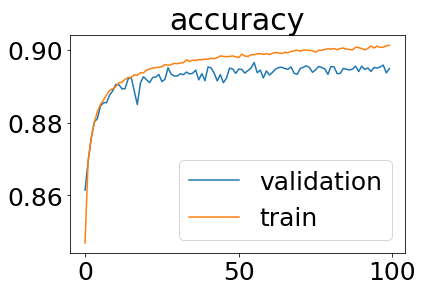

In [16]:
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.legend(['validation', 'train'])
plt.title("accuracy")

Text(0.5, 1.0, 'accuracy')

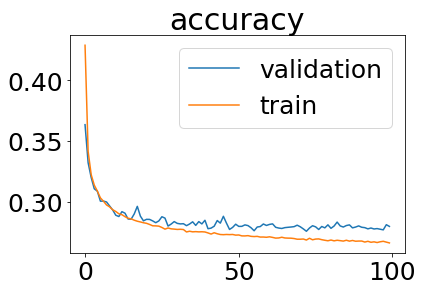

In [15]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['validation', 'train'])
plt.title("accuracy")

In [18]:
# Модель успешно обучилась, на примере синтетического продемонстрирована возможность применения 
# Wavelet Scattering для классификации сейсмических сигналов
# Значения метрик качества напрямую зависят от заданного соотношения сигнал/шум SNR
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
result = np.argmax(model.predict(X_test_sc), axis=1)
print('accuracy = ', np.round(accuracy_score(y_test, result), 4))
print('recall = ', np.round(recall_score(y_test, result), 4))
print('precision = ', np.round(precision_score(y_test, result), 4))

2500/2500 [==============================] - 22s 9ms/step
accuracy =  0.894
recall =  0.8004
precision =  0.9849
